In [1]:
## Importando Pacotes
import time
tic = time.time()

import pandas as pd
import numpy as np
from tqdm import tqdm
import duckdb
tqdm.pandas()
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta
import time
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

pd.options.display.float_format = '{:.2f}'.format

In [2]:
file_path = f'dados/df_cashout_teste_preds.parquet' ## dados do modelo 
file_path_og = 'dados/df_cashout_treino_feature_eng.parquet' ## dados originais 

## Carregando dataset
df_preds = pd.read_parquet(file_path)
df_og = pd.read_parquet(file_path_og)

In [3]:
def get_results_rule(df, rule, target, payer_id, transaction_amount):
    tamanho_base = len(df)
    dias_base = (df['transaction_datetime_request'].max() -df['transaction_datetime_request'].min()).days
    qty_clientes = df[payer_id].nunique()
    qty_maus = len(df[df[target] == 1])
    qty_bons = len(df[df[target] == 0])
    amount_maus = df[df[target] == 1][transaction_amount].sum()
    df_rule = df[df[rule] == 1]
    tamanho_base_regra_ = len(df_rule) if not df_rule.empty else 0
    qty_clientes_regra_ = df_rule[payer_id].nunique() if not df_rule.empty else 0
    qty_maus_regra_ = len(df_rule[df_rule[target] == 1]) if not df_rule[df_rule[target] == 1].empty else 0
    qty_bons_regra_ = len(df_rule[df_rule[target] == 0]) if not df_rule[df_rule[target] == 0].empty else 0
    amount_maus_regra_ = df_rule[df_rule[target] == 1][transaction_amount].sum() if not df_rule[df_rule[target] == 1].empty else 0
    
    print(f'Percentual da base na regra: {tamanho_base_regra_ / tamanho_base:.6%} ({tamanho_base_regra_})')
    print(f'Percentual da maus na regra: {qty_maus_regra_ / qty_maus:.6%} ({qty_maus_regra_})')
    print(f'Percentual da bons na regra: {qty_bons_regra_ / qty_bons:.6%} ({qty_bons_regra_})')
    print(f'Impacto/dia: {tamanho_base_regra_ / dias_base:2f} Trx por dia')
    print(f'Percentual do valor de maus na regra: {amount_maus_regra_ / amount_maus:.6%} (R$ {amount_maus_regra_:,.2f})')
    print(f'-'*40)
    # print(f'Relação de falso positivos: {qty_bons_regra_/(qty_bons_regra_+qty_maus_regra_):.2f}')
    if qty_maus_regra_ > 0: print(f'Relação de {qty_bons_regra_/qty_maus_regra_:.2f}:1')
    print(f'Percentual de clientes na regra: {qty_clientes_regra_ / qty_clientes:.6%} ({qty_clientes_regra_})')
    print(f'='*80)

In [4]:
feature_names = ['transaction_id', 'transaction_datetime_request',                
       'transaction_amount_total', 'sum_amount_same_doc_in_1H',
       'sum_amount_same_doc_in_7D', 'sum_amount_same_doc_in_30D',
       'count_amount_same_doc_in_1H', 'count_amount_same_doc_in_7D',
       'count_amount_same_doc_in_30D', 'mean_amount_same_doc_in_1H',
       'mean_amount_same_doc_in_7D', 'mean_amount_same_doc_in_30D',
       'std_amount_in_1H', 'std_amount_in_7D', 'std_amount_in_30D',
       'amount_7D_1H', 'amount_30d_7d', 'behav_increase_7d_1H_amount',
       'behav_increase_30d_7d_amount', 'flag_first_time_receiver',
       'desvio_relativo_media_in_1H', 'desvio_relativo_media_in_7D',
       'desvio_relativo_media_in_30D', 'last_status', 'transacoes_unicas_pagador_recebedor',
       'recebedores_unicos_por_pagador', 'pagadores_unicos_por_recebedor',
       'razao_valor_frequencia_1H', 'razao_valor_frequencia_7D', 'razao_valor_frequencia_30D',
       'roc_razao_valor_frequencia_1H','roc_razao_valor_frequencia_7D', 'roc_razao_valor_frequencia_30D',
       ]

df = df_og[df_og['transaction_datetime_request'] >= '2024-07-15'][feature_names]#.sort_values('transaction_id')

df = pd.merge(df, df_preds[['transaction_id', 'prob', 'predictions_cutoff_70', 'fraud']], on='transaction_id', how='left')

df['rejected'] = np.where(df['last_status'] == 'REJECTED', 1, 0)

df.rename(columns={'predictions_cutoff_70': 'y_pred'}, inplace=True)

pd.concat([df['fraud'].value_counts().rename('counts'),
df['fraud'].value_counts(normalize=True).rename('frequency')], axis=1)

,counts,frequency
fraud,,
0,7910621,1.00
1,29,0.00


In [5]:
df

,transaction_id,transaction_datetime_request,transaction_amount_total,sum_amount_same_doc_in_1H,sum_amount_same_doc_in_7D,sum_amount_same_doc_in_30D,count_amount_same_doc_in_1H,count_amount_same_doc_in_7D,count_amount_same_doc_in_30D,mean_amount_same_doc_in_1H,mean_amount_same_doc_in_7D,mean_amount_same_doc_in_30D,std_amount_in_1H,std_amount_in_7D,std_amount_in_30D,amount_7D_1H,amount_30d_7d,behav_increase_7d_1H_amount,behav_increase_30d_7d_amount,flag_first_time_receiver,desvio_relativo_media_in_1H,desvio_relativo_media_in_7D,desvio_relativo_media_in_30D,last_status,transacoes_unicas_pagador_recebedor,recebedores_unicos_por_pagador,pagadores_unicos_por_recebedor,razao_valor_frequencia_1H,razao_valor_frequencia_7D,razao_valor_frequencia_30D,roc_razao_valor_frequencia_1H,roc_razao_valor_frequencia_7D,roc_razao_valor_frequencia_30D,prob,y_pred,fraud,rejected
0,1ef423d2eaf1672abd84107fb4bf2ad4,2024-07-15 00:00:00.692,20.00,47950.45,3995298.44,18154704.45,352,28350,134258,136.22,140.93,135.22,742.96,602.24,564.99,27998,105908,79.54,0.79,0,0.15,0.14,0.15,APPROVED,134258,1118,538,133.65,140.52,134.89,-0.00,0.00,-0.00,0.08,0,0,0
1,1ef423d30f1169e8b6e7a13e87b70080,2024-07-15 00:00:04.600,150.00,150.00,150.00,200.00,1,1,2,150.00,150.00,100.00,0.00,0.00,70.71,0,1,0.00,0.50,0,1.00,1.00,1.50,APPROVED,2,96418,1,137.08,213.26,213.99,0.00,0.00,-0.00,0.02,0,0,0
2,1ef423d31b446c94b6e70079c39d5c92,2024-07-15 00:00:05.733,287.00,48237.45,3995585.44,18154991.45,353,28351,134259,136.65,140.93,135.22,741.95,602.23,564.99,27998,105908,79.31,0.79,0,2.10,2.04,2.12,APPROVED,134259,1118,538,134.07,140.53,134.90,0.00,0.00,0.00,0.11,0,0,0
3,1ef423d32e736ae1b6e7b783f47cf352,2024-07-15 00:00:07.978,180.42,180.42,664.50,1356.49,1,4,9,180.42,166.12,150.72,0.00,91.77,111.19,3,5,3.00,0.56,0,1.00,1.09,1.20,APPROVED,9,9330,1,194.55,298.27,285.08,-0.00,-0.00,0.00,0.13,0,0,0
4,1ef423d359d06ae3bd84e34ea4176904,2024-07-15 00:00:12.000,75.00,1769.50,226859.80,507992.15,35,2829,7067,50.56,80.19,71.88,128.05,704.23,489.92,2794,4238,79.83,0.60,0,1.48,0.94,1.04,APPROVED,7067,395,2,52.70,106.26,86.23,0.05,0.00,-0.00,0.42,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7910645,e270840982024110622538qh9ozqxgyh,2024-11-06 22:53:18.516,50.00,50.00,50.00,50.00,1,1,1,50.00,50.00,50.00,0.00,0.00,0.00,0,0,0.00,0.00,1,1.00,1.00,1.00,APPROVED,1,160367,1,213.73,207.71,178.64,-0.00,-0.00,0.00,0.00,0,0,0
7910646,e27084098202411062253q9sackdxm2o,2024-11-06 22:53:20.084,0.01,0.01,0.01,0.01,1,1,1,0.01,0.01,0.01,0.00,0.00,0.00,0,0,0.00,0.00,1,1.00,1.00,1.00,APPROVED,1,1387,1,0.01,236.74,202.19,0.00,-0.00,-0.00,0.17,0,0,0
7910647,e27084098202411062253byfqpmittsb,2024-11-06 22:53:20.424,0.01,0.01,0.01,0.01,1,1,1,0.01,0.01,0.01,0.00,0.00,0.00,0,0,0.00,0.00,1,1.00,1.00,1.00,APPROVED,1,37254,1,0.01,0.01,0.01,0.00,0.00,0.00,0.17,0,0,0
7910648,e27084098202411062253a26y2jxzjkl,2024-11-06 22:53:20.992,36.00,36.00,36.00,36.00,1,1,1,36.00,36.00,36.00,0.00,0.00,0.00,0,0,0.00,0.00,1,1.00,1.00,1.00,APPROVED,1,55538,2,125.97,509.15,843.22,0.00,-0.00,-0.00,0.00,0,0,0


### regras

tudo com base de teste, as regras vao ficar overfittadas

- testar ponto de corte do modelo 
- testar quais variaveis eliminam FP

In [6]:
# regra de prob do modelo
df['menor_que_38'] = np.where((df['prob']<.38), 1, 0)

In [7]:
# regra de prob do modelo
df['maior_ou_igual_38'] = np.where((df['prob']>=.38), 1, 0)

In [8]:
# ## decision tree  prob == .21, todas as features
# df['regra_4'] = np.where(
#                         (df['roc_razao_valor_frequencia_1H']>80.9)
#                         # &(df['prob']>=.4)
#                         &(df['prob']>=.5)
#                         , 1, 0)


In [9]:
# ## decision tree 20%
# df['regra_5'] = np.where((df["roc_razao_valor_frequencia_30D"] > 0.0009226450056303293)
#                         # &(df['prob']>=.5)
#                         &(df['prob']>=.4)
#                         , 1, 0)

In [10]:
# DF apenas com prob <= 0.5
# df['regra_7'] = np.where((df["pagadores_unicos_por_recebedor"] > 530.5)&(df["count_amount_same_doc_in_30D"] <= 448.5), 1, 0)
# df = df.drop('regra_7', axis='columns')

In [11]:
# df["regra_9"] = np.where((df["pagadores_unicos_por_recebedor"] > 530.5)
#                          &(df["count_amount_same_doc_in_30D"] <= 448.5), 1, 0)

In [12]:
## DF apenas com prob > 0.5
# df["menor_que_380"] = np.where((df["roc_razao_valor_frequencia_1H"] > 80.9776840209961), 1, 0) ]
# df = df.drop('menor_que_380', axis='columns')

In [13]:
# ## decision tree  prob == .21, top 10 feaatures importance 
# df['regra_3'] = np.where(
#                         (df['roc_razao_valor_frequencia_30D']<=5)
#                         &(df['std_amount_in_30D']>1600)
#                         &(df['prob']>=.6)
#                         , 1, 0)

In [14]:
# # decision tree ->  piores valores de feature importance 
# df['regra_6'] = np.where((df["std_amount_in_1H"] > 2200.197021484375)
#                         # &(df['prob']>=.3)
#                         &(df['prob']>=.4)
#                         , 1, 0)

In [15]:
# ## DF apenas com prob <= 0.5
# df['regra_8'] = np.where((df["recebedores_unicos_por_pagador"] <= 22.5)
#                         &(df["mean_amount_same_doc_in_1H"] > 477.5168151855469)
#                         &(df['prob']>=.3)
#                         # &(df['prob']>=.4)
#                         , 1, 0) 

# ## todas as features (exceto prob)
# # n_rules=20
# # scoring = 'f1'
# # print(
# #     RuleHelper.get_top_rules(
# #                             "df_rf",
# #                             clf,
# #                             df_rf.columns,
# #                             max_depth=3,
# #                             n_rules=n_rules,
# #                             df_use_on_candidates=df_rf,
# #                             target_col="fraud",
# #                             candidates_scoring_func=scoring,
# #                             max_candidates=200,
# #                             max_activation_chance=0.05,
# #                             features_to_ignore=ignore)
# #     )

In [16]:
# cortes = np.linspace(.3, .4, 11)

# ## DF apenas com prob <= 0.5
# for corte in cortes:
#     rulename = f'regra_8_{corte}'
#     df[rulename] = np.where((df["recebedores_unicos_por_pagador"] <= 22.5)
#                             &(df["mean_amount_same_doc_in_1H"] > 477.5168151855469)
#                             &(df['prob']>=corte)
#                             # &(df['prob']>=.4)
#                             , 1, 0) 
#     print('>'*4, rulename)
#     get_results_rule(df, rulename, 'fraud', 'transaction_id','transaction_amount_total')
#     print('\n')

### Metricas

### encontrar fraudes diferentes nas regras 

- 2 base de teste (corte no 0.5 da prob)
- roda a decision tree nas 2 separadas 
- e tenta encontrar regras nessas 2 bases

In [18]:
df['regras'] = np.where(
(df['menor_que_38'] == 1) |
(df['maior_ou_igual_38'] == 1) 
#|  
# (df['regra_3'] == 1) | 
# (df['regra_4'] == 1) |
# (df['regra_5'] == 1) |
# (df['regra_6'] == 1) |
# (df['regra_7'] == 1) |
# (df['regra_8'] == 1) #|
# (df['regra_9'] == 1) #|
                        , 1, 0)

regras = [
    'menor_que_38',
    'maior_ou_igual_38',
#     'regra_3',
#     # 'regra_4',
#     # 'regra_5', 
#     # 'regra_6', 
#     # 'regra_7', 
#     'regra_8',
#     # 'regra_9',
    'regras'
    ]

n_trx = len(df)
n_fraudes = len(df[df['fraud'] == 1])
dias_base = (df['transaction_datetime_request'].max() - df['transaction_datetime_request'].min()).days

print(f'Tamanho da base: {n_trx}')
print(f'Quantidade de maus: {n_fraudes}')
print(f'Quantidade de Dias (Base Teste): {dias_base}')
print(f'Trx/dia (Base Teste): {n_trx/dias_base}\n')

for regra in regras:
        print('>'*4, regra)
        get_results_rule(df, regra, 'fraud', 'transaction_id','transaction_amount_total')
        print('\n')

Tamanho da base: 7910650
Quantidade de maus: 29
Quantidade de Dias (Base Teste): 114
Trx/dia (Base Teste): 69391.66666666667

>>>> menor_que_38
Percentual da base na regra: 96.173677% (7607963)
Percentual da maus na regra: 34.482759% (10)
Percentual da bons na regra: 96.173903% (7607953)
Impacto/dia: 66736.517544 Trx por dia
Percentual do valor de maus na regra: 9.742332% (R$ 7,784.01)
----------------------------------------
Relação de 760795.30:1
Percentual de clientes na regra: 96.173677% (7607963)


>>>> maior_ou_igual_38
Percentual da base na regra: 3.826323% (302687)
Percentual da maus na regra: 65.517241% (19)
Percentual da bons na regra: 3.826097% (302668)
Impacto/dia: 2655.149123 Trx por dia
Percentual do valor de maus na regra: 90.257668% (R$ 72,114.83)
----------------------------------------
Relação de 15929.89:1
Percentual de clientes na regra: 3.826323% (302687)


>>>> regras
Percentual da base na regra: 100.000000% (7910650)
Percentual da maus na regra: 100.000000% (29)


In [19]:
rules_cols = []
for col in df.columns:
    if "regra" in col: rules_cols.append(col)

In [20]:
# TRX com mais de 1 regras ativada 

df[df['regras']==1][rules_cols].T.sum()[df[df['regras']==1][rules_cols].T.sum() > 2]

Series([], dtype: int64)

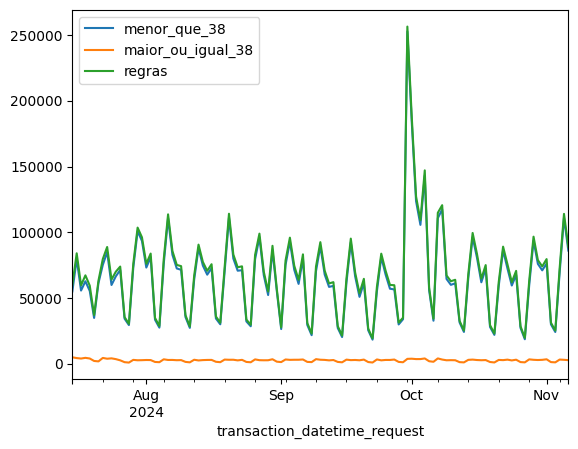

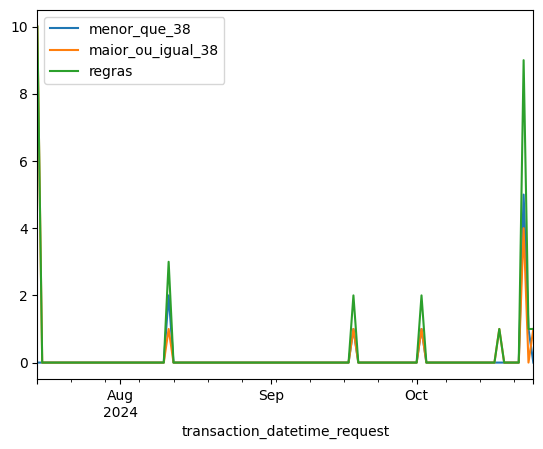

In [22]:
df.resample( "D", on = "transaction_datetime_request")[regras].sum().plot();
df[df['fraud']==1].resample( "D", on = "transaction_datetime_request")[regras].sum().plot();

In [23]:
from time import *

toc = time()

def convert_seconds(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

time_format = convert_seconds(toc-tic)

print(f'Tempo de Processamento: {time_format}')

Tempo de Processamento: 00:02:34
